In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
#hide
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)


In [3]:
Path.BASE_PATH = path

In [4]:
path

Path('.')

In [5]:
sevens = (path/'train/7').ls()
threes = (path/'train/3').ls()
sevens_stack = torch.stack([tensor(Image.open(o)) for o in sevens]).float() / 255
threes_stack = torch.stack([tensor(Image.open(o)) for o in threes]).float() / 255


In [6]:
mean7 = sevens_stack.mean(0)
mean3 = threes_stack.mean(0)


In [7]:
def minst_dist(a, b): return (a - b).abs().mean()

In [8]:
def is_3(o): return minst_dist(o, mean3) < minst_dist(o, mean7)

In [9]:
is_3(sevens_stack[3])

tensor(False)

In [10]:
valid_sevens_stack = torch.stack([tensor(Image.open(o)) for o in (path/'valid/7').ls()]).float() / 255
valid_threes_stack = torch.stack([tensor(Image.open(o)) for o in (path/'valid/3').ls()]).float() / 255


In [11]:
(sum(1 - is_3(o).float() for o in valid_sevens_stack) / len(valid_sevens_stack),
sum(is_3(o).float() for o in valid_threes_stack) / len(valid_threes_stack))


(tensor(0.9854), tensor(0.9168))

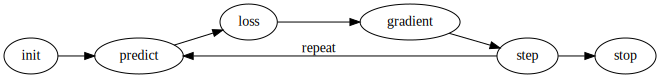

In [12]:
gv('''
init->predict -> loss ->gradient->step->stop
step->predict[label=repeat]
''')

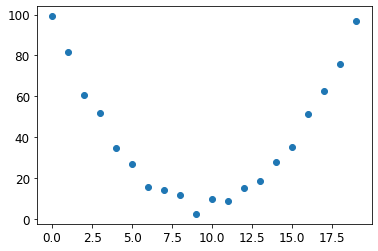

In [13]:
# Rollercoaster
time = torch.arange(20).float()

speed = 9*torch.rand(20).float() + (time-9.5)**2 + 1

plt.scatter(time, speed)

In [14]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-100,300)

In [15]:

def f(x, params):
    a, b, c = params
    return a * x**2 + b * x + c

loss tensor(1536.5359, grad_fn=<MeanBackward0>)
loss tensor(1335.2625, grad_fn=<MeanBackward0>)
loss tensor(1297.1687, grad_fn=<MeanBackward0>)
loss tensor(1289.9537, grad_fn=<MeanBackward0>)
loss tensor(1288.5818, grad_fn=<MeanBackward0>)
loss tensor(1288.3157, grad_fn=<MeanBackward0>)
loss tensor(1288.2589, grad_fn=<MeanBackward0>)
loss tensor(1288.2415, grad_fn=<MeanBackward0>)
loss tensor(1288.2317, grad_fn=<MeanBackward0>)
loss tensor(1288.2234, grad_fn=<MeanBackward0>)
loss tensor(1288.2155, grad_fn=<MeanBackward0>)
loss tensor(1288.2074, grad_fn=<MeanBackward0>)
loss tensor(1288.1992, grad_fn=<MeanBackward0>)
loss tensor(1288.1912, grad_fn=<MeanBackward0>)
loss tensor(1288.1833, grad_fn=<MeanBackward0>)
loss tensor(1288.1750, grad_fn=<MeanBackward0>)
loss tensor(1288.1672, grad_fn=<MeanBackward0>)
loss tensor(1288.1592, grad_fn=<MeanBackward0>)
loss tensor(1288.1511, grad_fn=<MeanBackward0>)
loss tensor(1288.1431, grad_fn=<MeanBackward0>)
loss tensor(1288.1350, grad_fn=<MeanBack

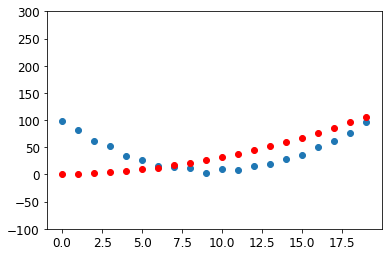

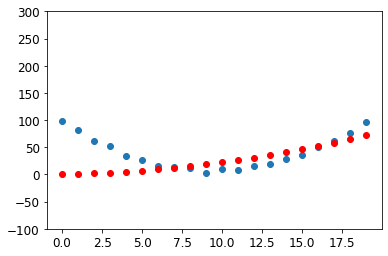

In [16]:

weights = torch.rand(3).float().requires_grad_()


def mse(preds, targets):
    return ((targets - preds)**2).mean()

lr = 1e-5
def epoch(weights):
    #print('weights', weights)
    preds = f(time, weights)
    loss = mse(preds, speed)
    print('loss', loss)
    loss.backward()
    weights.data -= weights.grad.data * lr
    weights.grad = None
    return weights

preds = f(time, weights)
show_preds(preds)
for _ in range(40):
    weights = epoch(weights)
preds = f(time, weights)
show_preds(preds)

In [17]:
t = torch.empty(5, 6, 7)
t.size(), t.ndim, t.shape, len(t)

(torch.Size([5, 6, 7]), 3, torch.Size([5, 6, 7]), 5)

In [18]:

#1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.

(torch.tensor([[i*3+j+1 for j in range(3)] for i in range(3)]) * 2)[-2:,-2:]

tensor([[10, 12],
        [16, 18]])

## MNIST loss func

In [19]:
train_x = torch.cat([threes_stack, sevens_stack]).view(-1, 28*28)
train_y = tensor([0] * len(threes_stack) + [1] * len(sevens_stack)).unsqueeze(1)
dset = list(zip(train_x, train_y))
train_x.shape, train_y.shape, train_x[0].shape

(torch.Size([12396, 784]), torch.Size([12396, 1]), torch.Size([784]))

In [20]:
valid_x = torch.cat([valid_threes_stack, valid_sevens_stack]).view(-1, 28*28)
valid_y = tensor([0] * len(valid_threes_stack) + [1] * len(valid_sevens_stack)).unsqueeze(1)
vdset = list(zip(valid_x, valid_y))
valid_x.shape, valid_y.shape


(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [21]:
def init_params(size, std=1.0): return (torch.randn(size) * std).requires_grad_()

In [22]:
weights = init_params((28*28, 1))
bias = init_params(1)
bias, weights.shape, len(weights[0])

(tensor([1.1797], requires_grad=True), torch.Size([784, 1]), 1)

In [35]:
def linear1(xb, params):
    weights, bias = params
    return xb@weights + bias

In [36]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()


In [44]:

def train_epoch(model, params, lr=1.0):
    optimizer = SGD(params, lr)
    for dx, dy in DataLoader(dset, batch_size=256):
        # pred
        predictions = model(dx, params)
        # loss
        loss = mnist_loss(predictions, dy)
        # gradient
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # update params
        #for p in params:
        #    p.data -= lr * p.grad
        #    p.grad.zero_()
        

In [45]:
for _ in range(20):
    train_epoch(linear1, (weights, bias))
    metric = ((linear1(valid_x, (weights, bias)) > 0.5) == valid_y).float().mean()
    print('{0:.4}'.format(metric), end=' ')

0.9774 0.9779 0.9784 0.9784 0.9784 0.9784 0.9784 0.9784 0.9784 0.9784 0.9784 0.9784 0.9784 0.9784 0.9779 0.9784 0.9784 0.9784 0.9784 0.9784 

In [47]:
dl = DataLoaders(dset, vdset)
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()
learner = Learner(dl, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learner.fit(5, lr=1.)
learner.recorder.values

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.000004,0.493423,0.504416,00:23
1,0.000001,0.407800,0.586359,00:23
2,0.000000,0.359367,0.639843,00:24
3,0.000001,0.245744,0.755152,00:26
4,0.000000,0.224943,0.776251,00:24


[(#3) [3.701334208017215e-06,0.4934232831001282,0.5044161081314087],
 (#3) [5.241442977421684e-07,0.40779951214790344,0.5863592028617859],
 (#3) [1.0901690927767049e-07,0.3593670427799225,0.6398429870605469],
 (#3) [1.3686161537407315e-06,0.2457437962293625,0.7551521062850952],
 (#3) [1.1327322368970272e-07,0.2249431163072586,0.7762512564659119]]

<AxesSubplot:>

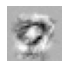

In [64]:
m = learner.model
show_image(next(m.parameters()).view(28, 28))

0.6168 0.7188 0.7797 0.8268 0.866 0.8886 0.9063 0.9161 0.9254 0.9293 0.9318 0.9357 0.9411 0.9441 0.946 0.9485 0.9509 0.9514 0.9514 0.9514 

/opt/conda/lib/python3.7/site-packages/fastai/torch_core.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if ax is None: _,ax = plt.subplots(figsize=figsize)


0.9529 0.9529 0.9534 0.9534 0.9544 0.9553 0.9558 0.9563 0.9563 0.9563 0.9563 0.9558 0.9558 0.9563 0.9573 0.9578 0.9578 0.9588 0.9588 0.9593 0.9603 0.9603 0.9607 0.9607 0.9607 0.9607 0.9607 0.9607 0.9607 0.9612 

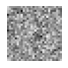

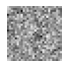

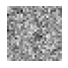

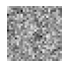

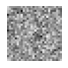

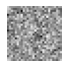

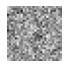

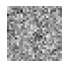

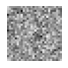

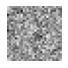

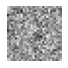

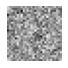

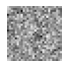

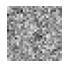

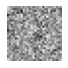

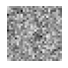

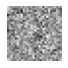

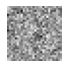

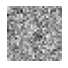

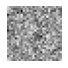

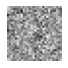

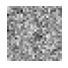

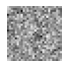

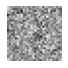

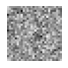

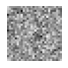

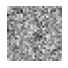

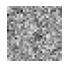

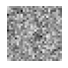

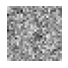

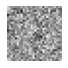

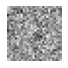

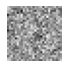

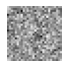

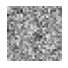

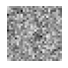

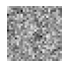

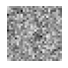

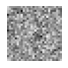

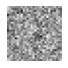

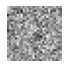

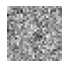

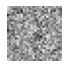

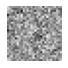

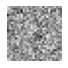

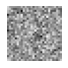

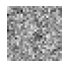

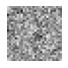

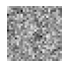

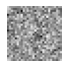

In [77]:
w1 = init_params((28*28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)

def nnet2(xd, params):
    w1, b1, w2, b2 = params
    res = xd@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

params = (w1, b1, w2, b2)
for _ in range(50):
    train_epoch(nnet2, params, lr=0.1)
    metric = ((nnet2(valid_x, params) > 0.5) == valid_y).float().mean().item()
    show_image(params[0][0:,0].view(28,28))
    print('{0:.4}'.format(metric), end=' ')
    